In [24]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# custom package
import plotting_tools as pt
%matplotlib inline

from matplotlib.patches import Ellipse
from scipy.stats import norm

# this is a module I created
from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing
from sklearn import manifold

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

import kcorrect

from scipy import linalg

import cluster_methods
from sklearn.mixture import GMM
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: metallicity
# 5: redshift
# 6: prob. elliptical
# 7: prob. spiral
# 8: prob. merger
# 9: u
# 10: g
# 11: r
# 12: i
# 13: z
# 14: u err
# 15: g err
# 16: r err
# 17: i err
# 18: z err
# 19: petro r
# 20: theta

# preprocessing, k-corrections, normalising data, cluster analysis

In [2]:
kcorrect.load_templates()
kcorrect.load_filters()

def perform_kcorrect(redshift,magnitudes,mag_ivars):
    # remember to apply AB magnitude offsets if required
    maggies = pow(10,-0.4*np.array(magnitudes))
    maggies_ivar = pow(0.4*np.log(10)*maggies*np.array(mag_ivars),-2)
    c = kcorrect.fit_nonneg(redshift,maggies,maggies_ivar)
    rm = kcorrect.reconstruct_maggies(c)
    rm0 = kcorrect.reconstruct_maggies(c,redshift=0.)
    return -2.5*np.log10(rm[1:]/rm0[1:])   

In [3]:
# load galaxies
galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/final_vespa_properties.npy')
galaxies.shape

(417270, 21)

In [149]:
rlim_galaxies = np.array([row for row in galaxies if 0.08>row[5]>0.004])
rlim_galaxies.shape

(137166, 21)

In [150]:
# plot un kcorrected CMD and remove obvious outliers
x = [(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10)) for row in rlim_galaxies]
y = [row[9]-row[11] for row in rlim_galaxies]

In [151]:
len(x)

137166

(-23, -16)

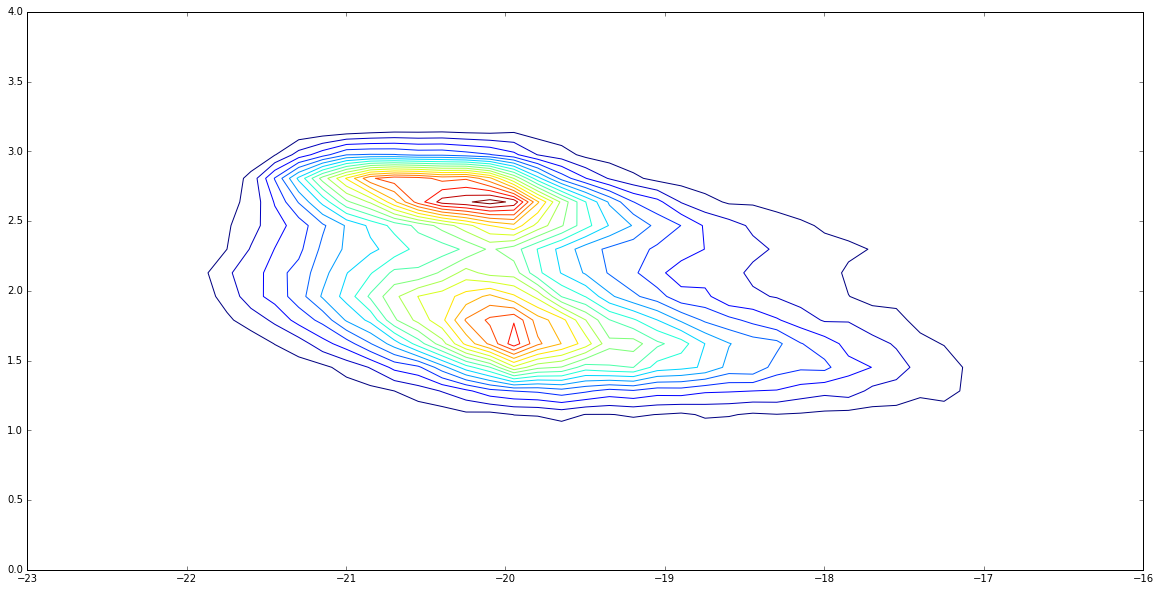

In [152]:
plt.figure(figsize=(20,10))
pt.plot_contour(x,y,bins=70)
plt.ylim(0.,4.)
plt.xlim(-23,-16)

In [153]:
kcorrections = []

for row in rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

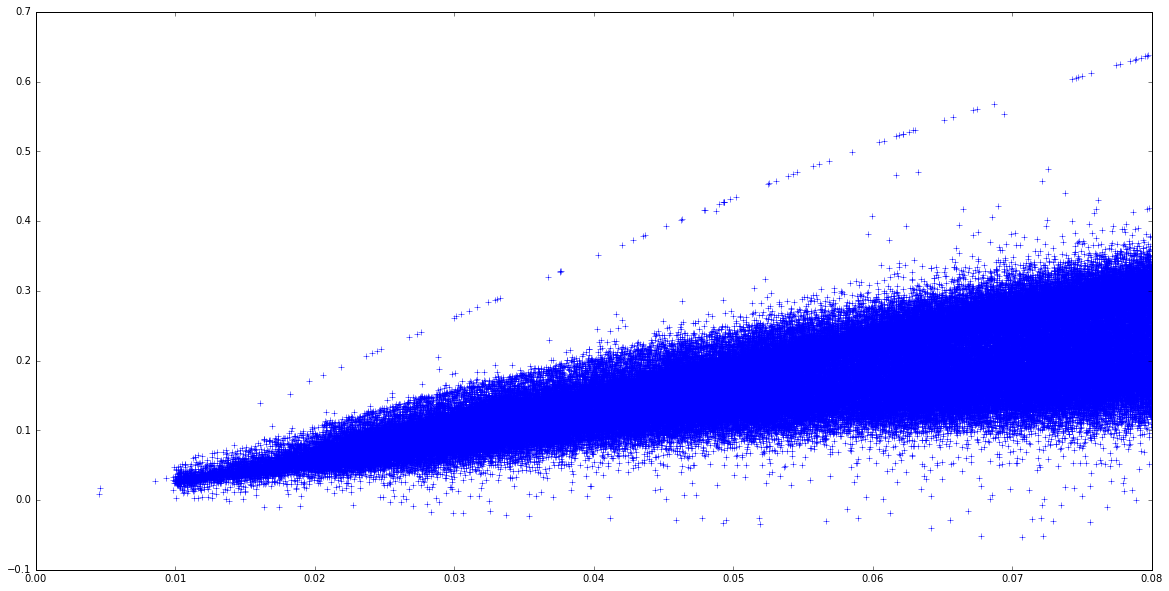

In [154]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][0] for row in kcorrections],'+')

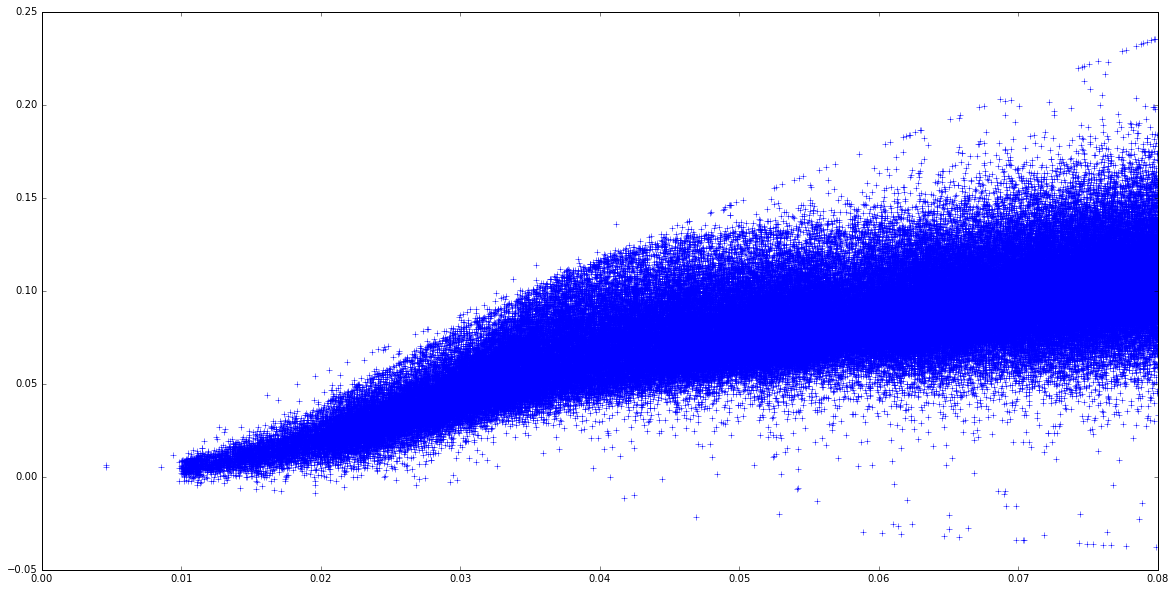

In [155]:
plt.figure(figsize=(20,10))
plt.plot([row[0] for row in kcorrections],[row[1][2] for row in kcorrections],'+')

In [156]:
len(y), len(kcorrections)

(137166, 137166)

In [157]:
kcorrect_y = []
kcorrect_x = []

for i,row in enumerate(y):
    kcorrect_x.append(x[i]-kcorrections[i][1][2])
    kcorrect_y.append(row-kcorrections[i][1][0]+kcorrections[i][1][2])

(-22.5, -16.5)

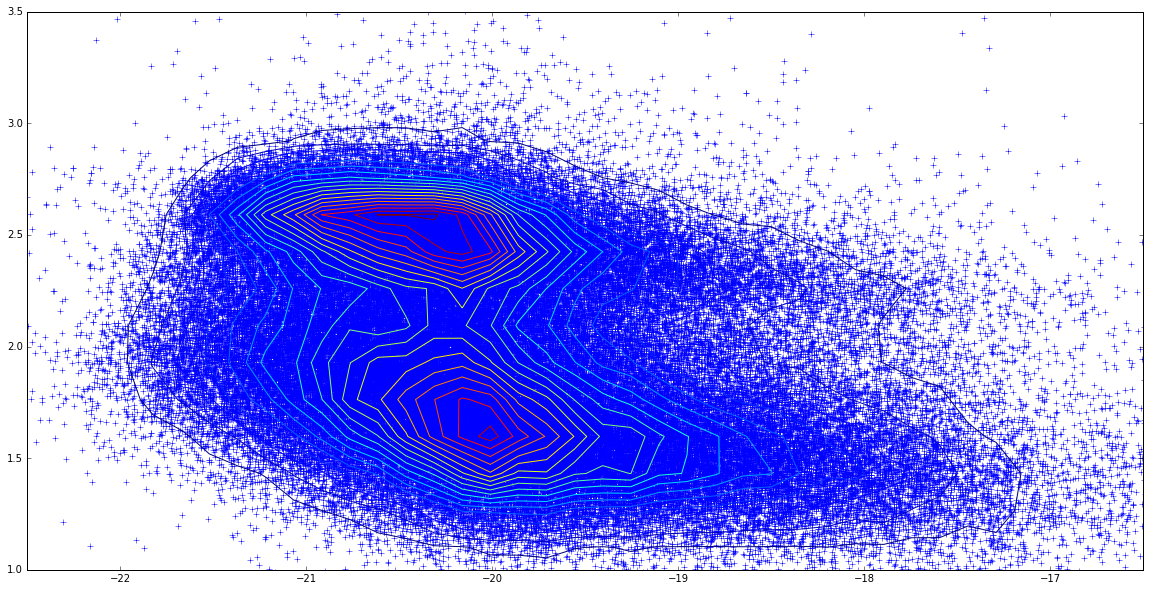

In [158]:
plt.figure(figsize=(20,10))
pt.plot_contour(kcorrect_x,kcorrect_y,bins=70)
plt.plot(kcorrect_x,kcorrect_y,'+')
plt.ylim(1.,3.5)
plt.xlim(-22.5,-16.5)

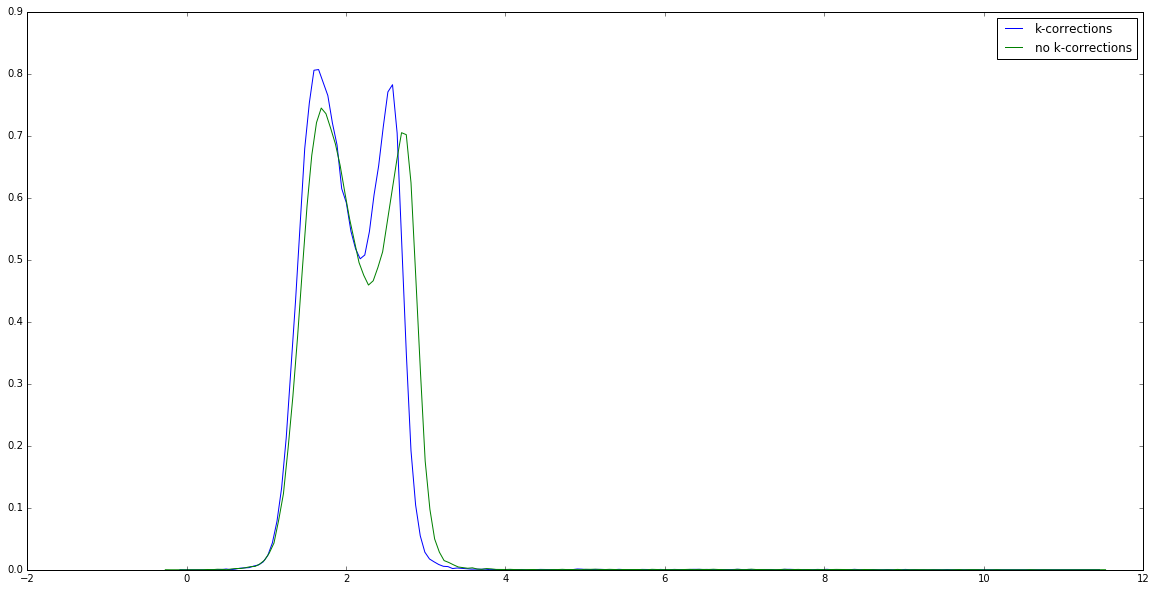

In [159]:
plt.figure(figsize=(20,10))
pt.plot_hist(kcorrect_y,200,'k-corrections')
pt.plot_hist(y,200,'no k-corrections')
plt.legend()

In [424]:
# remove outliers, only removes 500 obvious outliers
reduced_rlim_galaxies = []

for i, row in enumerate(rlim_galaxies):
    if 0.5 < kcorrect_y[i] < 3.6:
        reduced_rlim_galaxies.append(row)    
            
len(reduced_rlim_galaxies)

136810

In [425]:
# do kcorections again
kcorrections = []

for row in reduced_rlim_galaxies:
    # calculate kcorrections
    ktuple = perform_kcorrect(row[5],row[9:14],row[14:19])
    # store k-corrections
    kcorrections.append([row[5],ktuple]) 

In [524]:
# define dataset
data = []

#create dataset for clustering
for i,row in enumerate(reduced_rlim_galaxies):
    # absolute r-band petrosian magnitude
    x0 = float(row[19])-5*(np.log10(cosmo.luminosity_distance(row[5]).to(u.pc).value/10))-kcorrections[i][1][2]
    # k-corrected (u-r) colour
    x1 = row[9]-row[11]-kcorrections[i][1][0]+kcorrections[i][1][2]
    # redshift
    x2 = row[4]
    # morphological parameters
    x3 = 0
    x4 = 0
    x5 = 0
    if row[6] > 0.8:
        x3 = 1            
    if row[7] > 0.8:
        x4 = 1
    if row[8] > 0.8:
        x5 = 1
    # ISM dust value
    x6 = row[3]
    # log(stellar mass)
    x7 = np.log(row[0])
    # SFR last 115 Myr
    x8 = row[2]
    # metallicity average in last 5 age bins (115 Myr)
    x9 = row[4]
    # surface brightness
    x10 = row[19]+2.5*np.log10(2*np.pi*row[20]*row[20])
        
    # append to data
    data.append([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10])

In [427]:
data = np.array(data)
data.shape

(136810, 11)

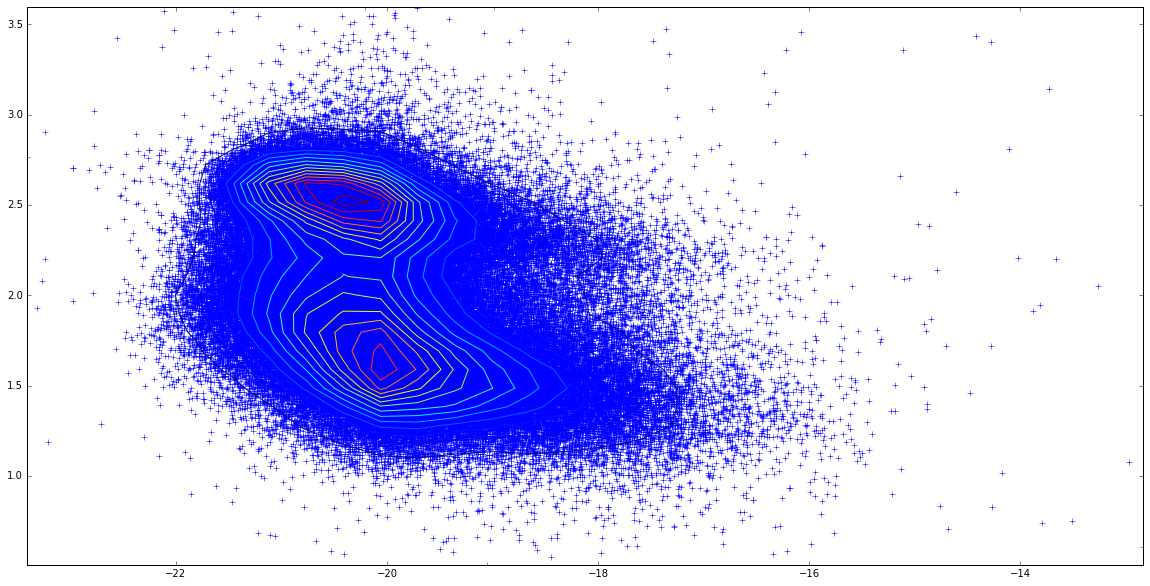

In [428]:
plt.figure(figsize=(20,10))
pt.plot_contour([row[0] for row in data],[row[1] for row in data],bins=30)
plt.plot([row[0] for row in data],[row[1] for row in data],'+')

In [429]:
# scale data before manifold learning
# select rows that will be used for clustering
data_clustering = [ [row[0],row[1],row[3],row[4],row[5],row[6],row[7],row[10]] for row in data]
data_scaled = preprocessing.scale(data_clustering)

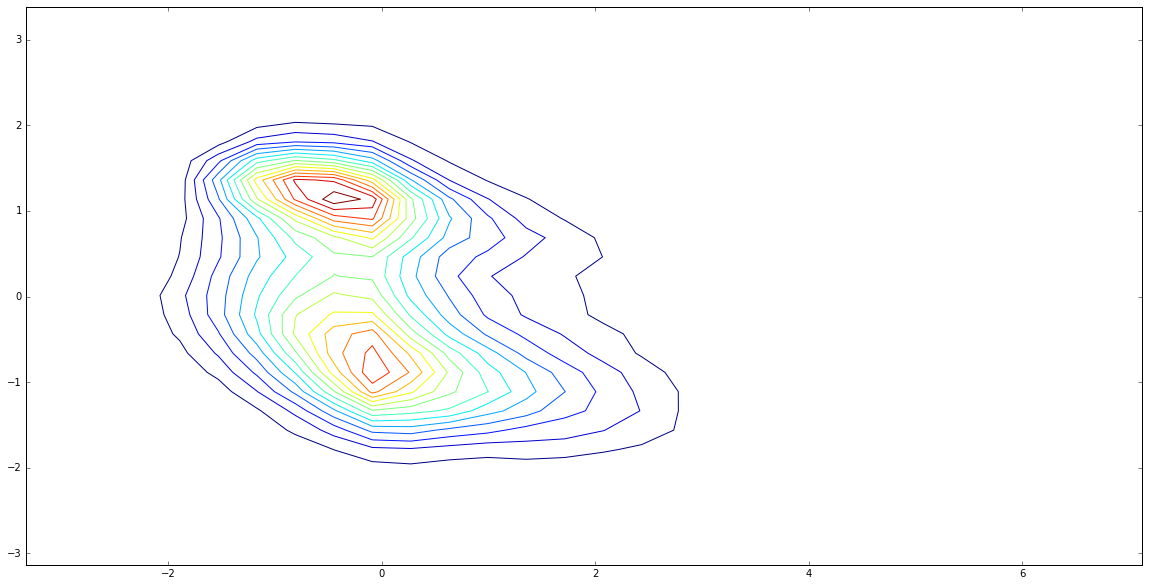

In [430]:
plt.figure(figsize=(20,10))
#pt.plot_contour([row[0] for row in data_scaled[sample_number]],[row[1] for row in data_scaled[sample_number]],bins=30)
pt.plot_contour([row[0] for row in data_scaled],[row[1] for row in data_scaled],bins=30)
#plt.plot([row[0] for row in data_scaled[sample_number]],[row[1] for row in data_scaled[sample_number]],'+')

In [431]:
sample_number = np.random.choice(np.array([i for i  in range(0,171992)]),21499)

In [23]:
sample_number[:10]

array([ 42152, 157522, 108018, 130793,  59064, 116976,  95985,  48229,
        41572, 117838])

In [107]:
# use manifold learning technique Modified Locally Linear Embedding
lle = manifold.LocallyLinearEmbedding(n_neighbors=12,n_components=4)

In [108]:
lle.fit_transform(data_scaled[sample_number])

array([[ -4.30793898e-11,  -7.00810831e-03,   4.38829375e-03,
         -3.01406032e-03],
       [ -5.23251667e-11,  -7.00810851e-03,   4.39458199e-03,
         -2.88362231e-03],
       [ -5.43837816e-11,  -7.00810859e-03,   4.39273969e-03,
         -2.73091107e-03],
       ..., 
       [ -6.33712069e-11,  -7.00810840e-03,   4.40362686e-03,
         -2.83585104e-03],
       [  1.59935017e-10,  -7.00808739e-03,  -1.06687338e-02,
         -1.89843689e-03],
       [  1.61743535e-10,  -7.00808829e-03,  -1.02079083e-02,
          1.06953759e-03]])

In [109]:
lle_data = lle.transform(data_scaled)

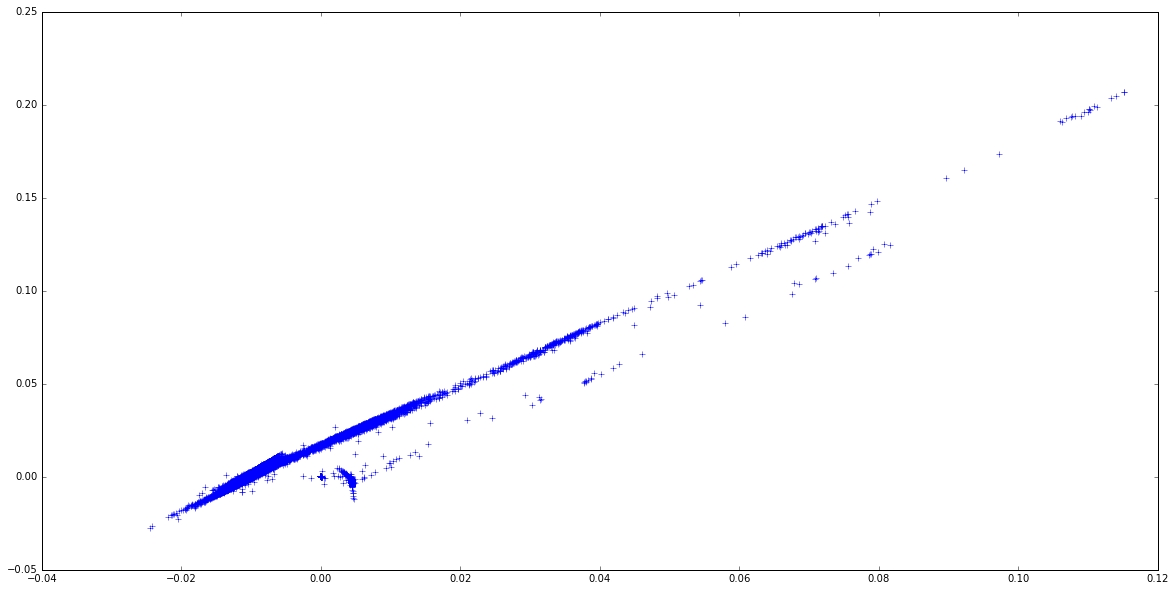

In [122]:
plt.figure(figsize=(20,10))
plt.plot([row[2] for row in lle_data],[row[3] for row in lle_data],'+')

In [126]:
pca = decomposition.PCA(n_components=4)

In [127]:
data_pca = pca.fit_transform(data_scaled)

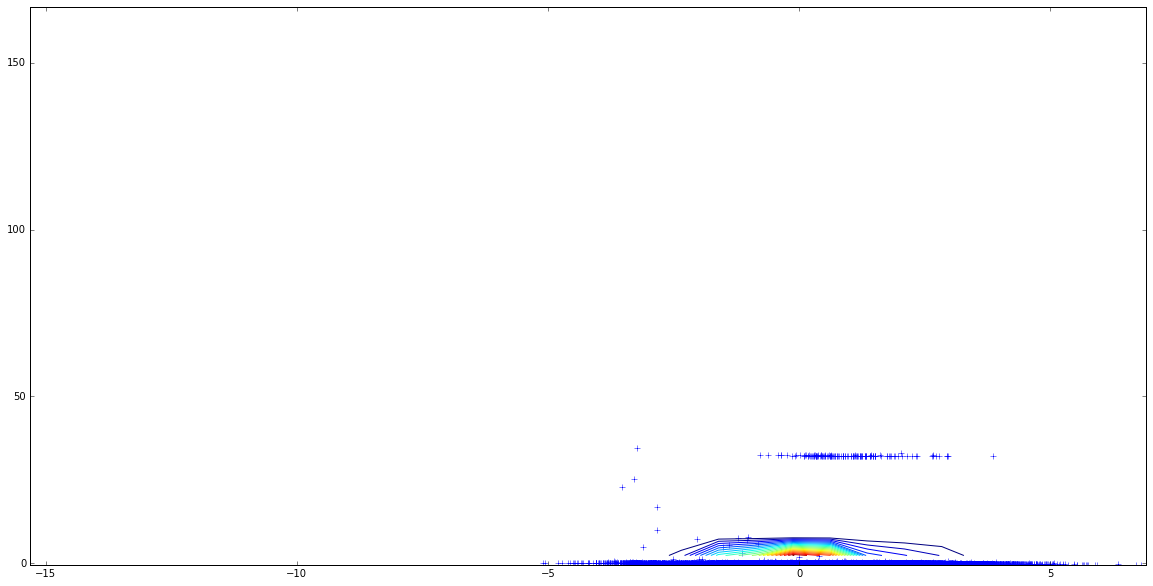

In [139]:
plt.figure(figsize=(20,10))
i = 2
j = 3
pt.plot_contour([row[i] for row in data_pca],[row[j] for row in data_pca])
plt.plot([row[i] for row in data_pca],[row[j] for row in data_pca],'+')

In [ ]:
# perform fuzzy cluster analysis

In [441]:
data_scaled.shape

(136810, 8)

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


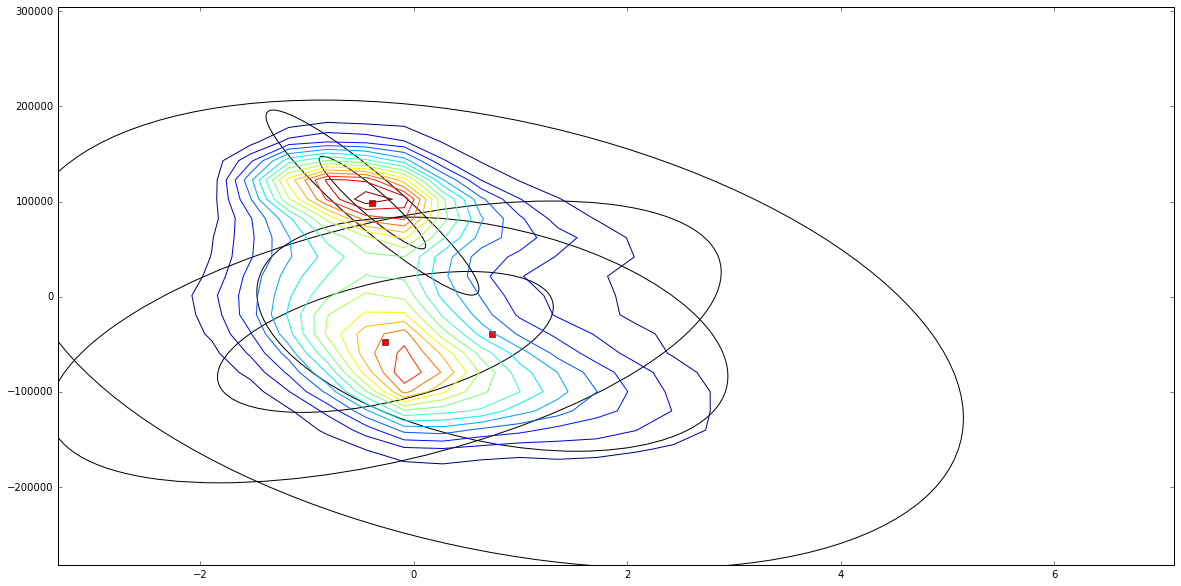

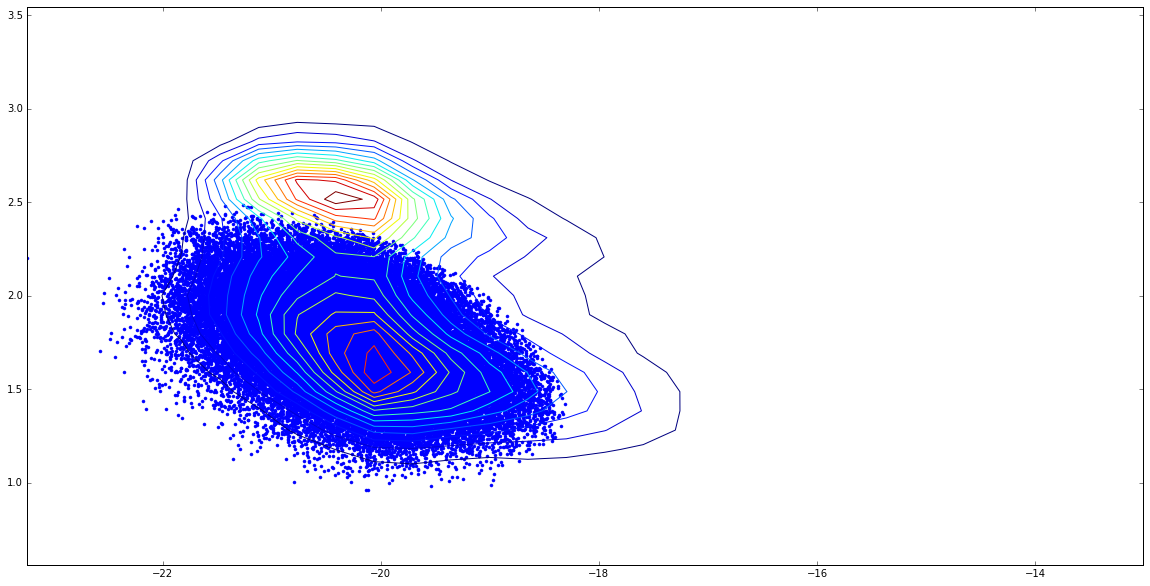

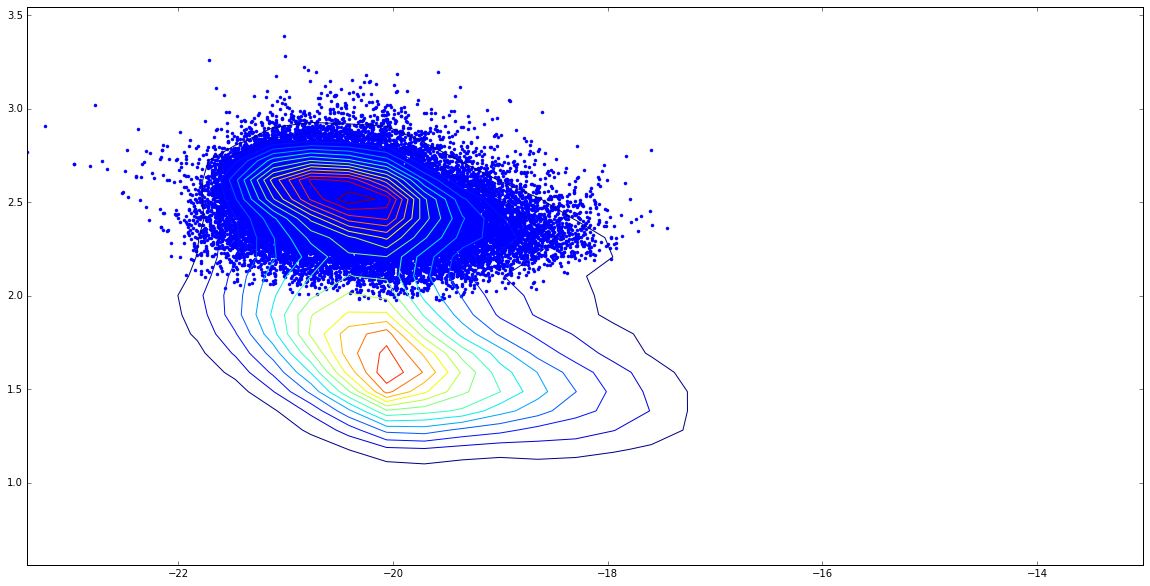

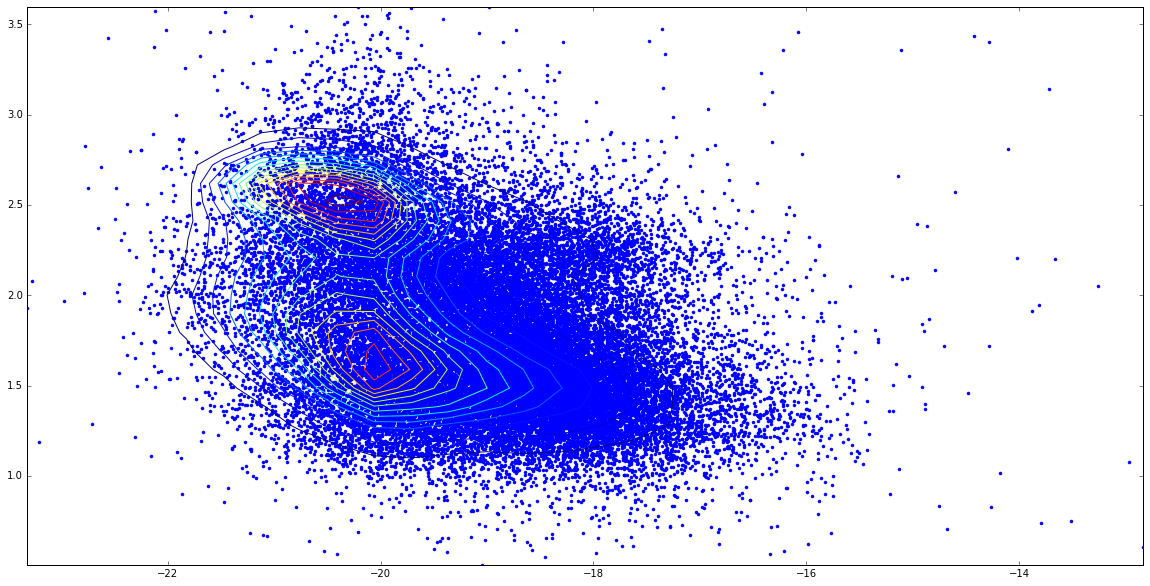

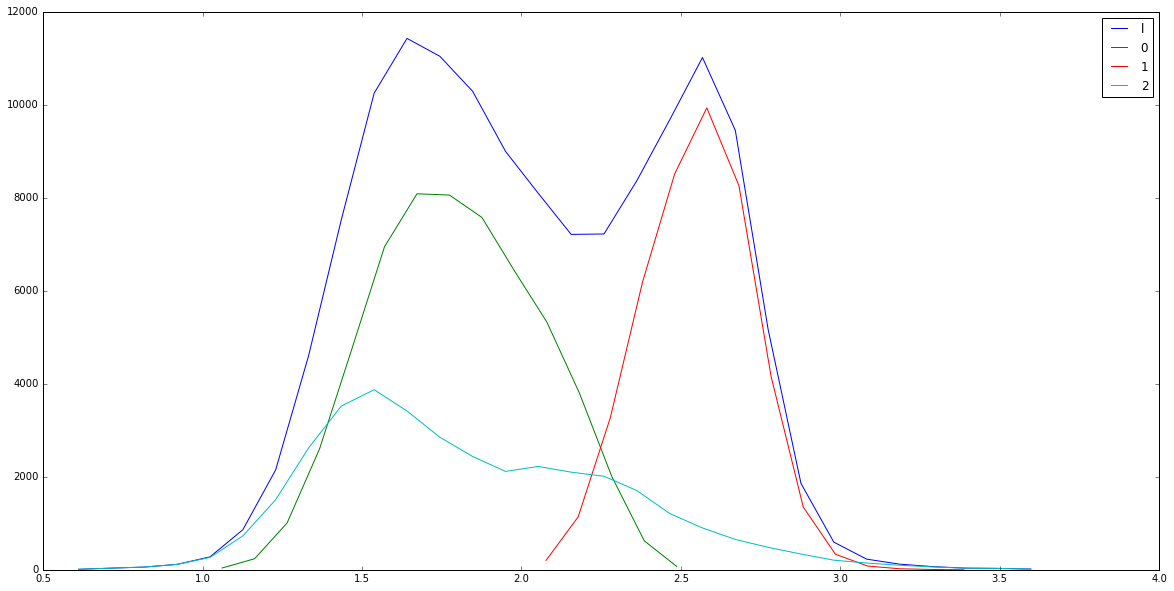

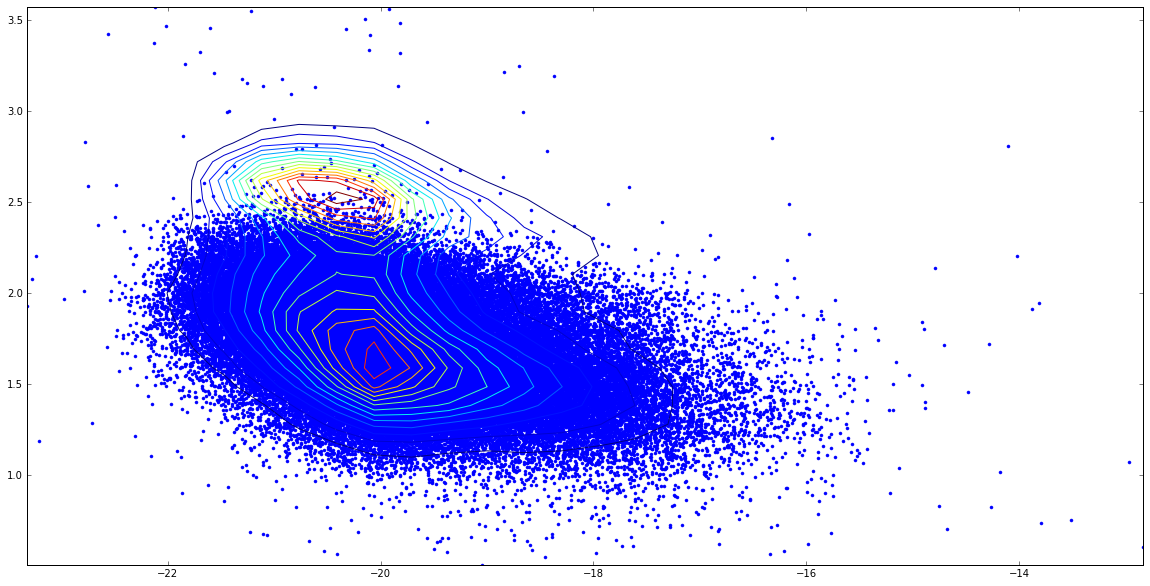

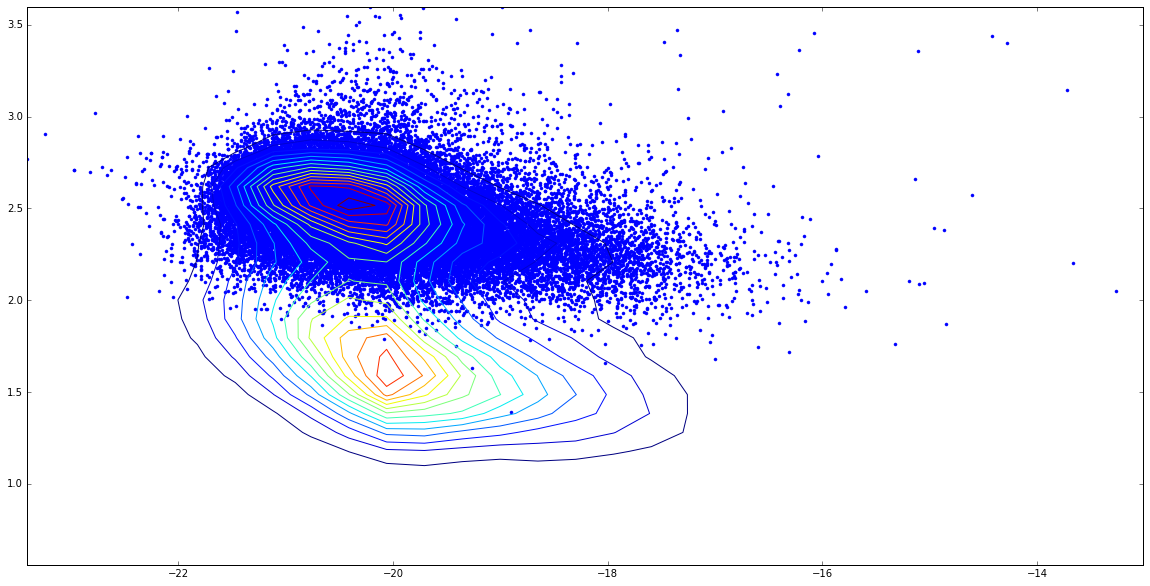

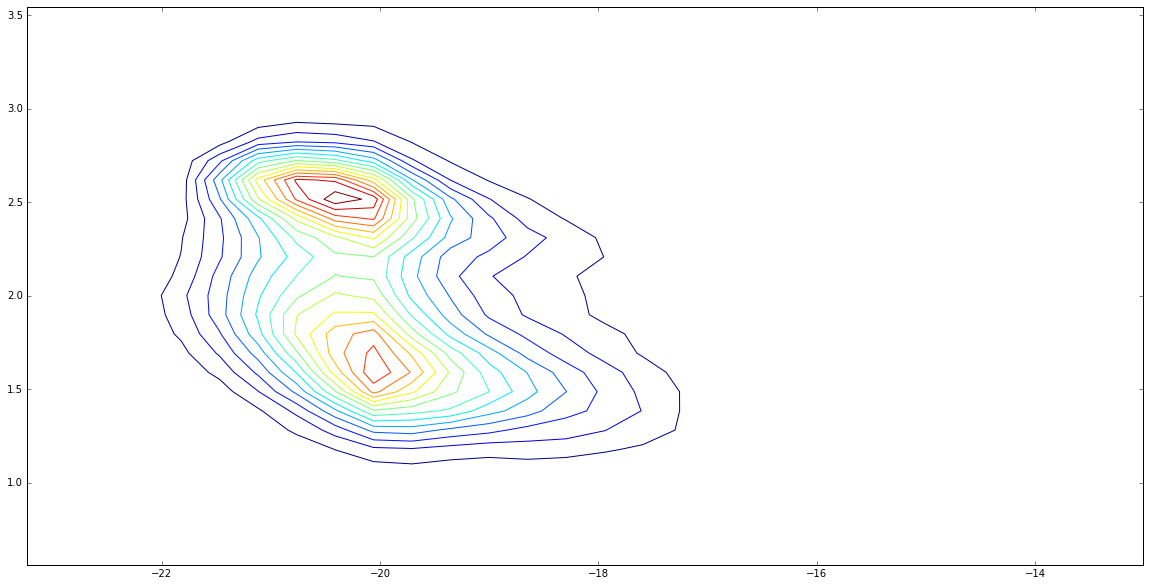

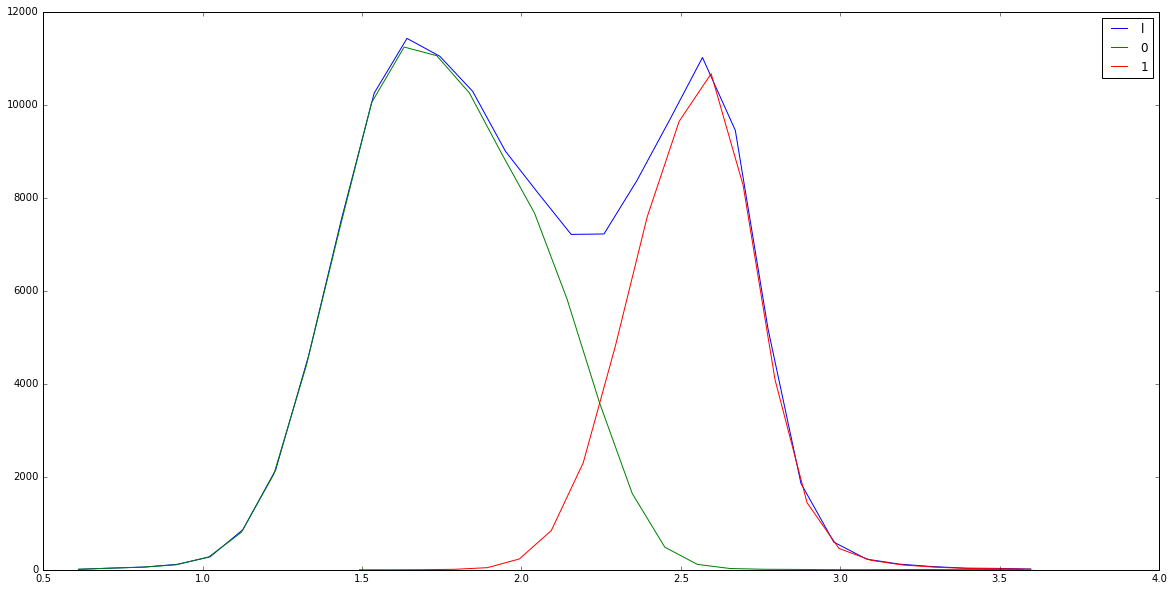

In [644]:
cluster_probs = cluster_methods.gmm_clustering(data,[[row[0],row[1]*90000,row[5],row[6],row[7]] for row in data_scaled],3,500,'mc','full')

In [651]:
clusters_zero = []

for row in cluster_probs:
    if row[0] > 0.1 and row[0] < .8  and row[1] > 0.1 and row[1] < .8:
        clusters_zero.append(1)
    else:
        clusters_zero.append(0)
        
clusters_zero = np.array(clusters_zero) 


cluster_membership = np.argmax(cluster_probs.T[:2], axis=0)

cluster_probs_excluding_green_valley = np.argmax(cluster_probs[clusters_zero==0].T[1:],axis=0)



In [652]:
x = np.array([row[0] for row in data])
y = np.array([row[1] for row in data])

In [653]:
np.array(x[clusters_zero==1]).shape , clusters_one.shape, cluster_probs[clusters_zero==0].T[:2].shape

((7681,), (136810,), (2, 129129))

(1, 4)

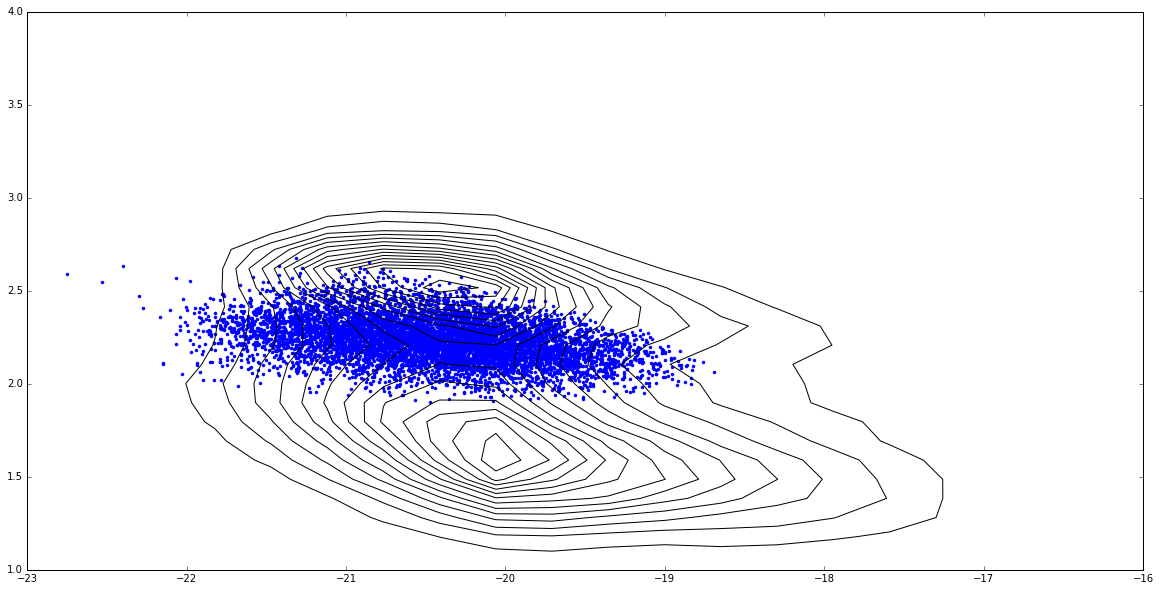

In [654]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,colours='k')
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'.')
#plt.plot(x[clusters_one == 1],y[clusters_one == 1],'.')
#pt.plot_contour(x[clusters_zero == 1],y[clusters_zero == 1])
#pt.plot_contour(x[clusters_one == 1],y[clusters_one == 1])

plt.xlim(-23,-16)
plt.ylim(1,4)

In [655]:
x1 = []
y1 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 0:
        if clusters_zero[i] == 0:
            y1.append(row)
            x1.append(x[i])
x2 = []            
y2 = []

for i,row in enumerate(y):
    if cluster_membership[i] == 1:
        if clusters_zero[i] == 0:
            y2.append(row)
            x2.append(x[i])

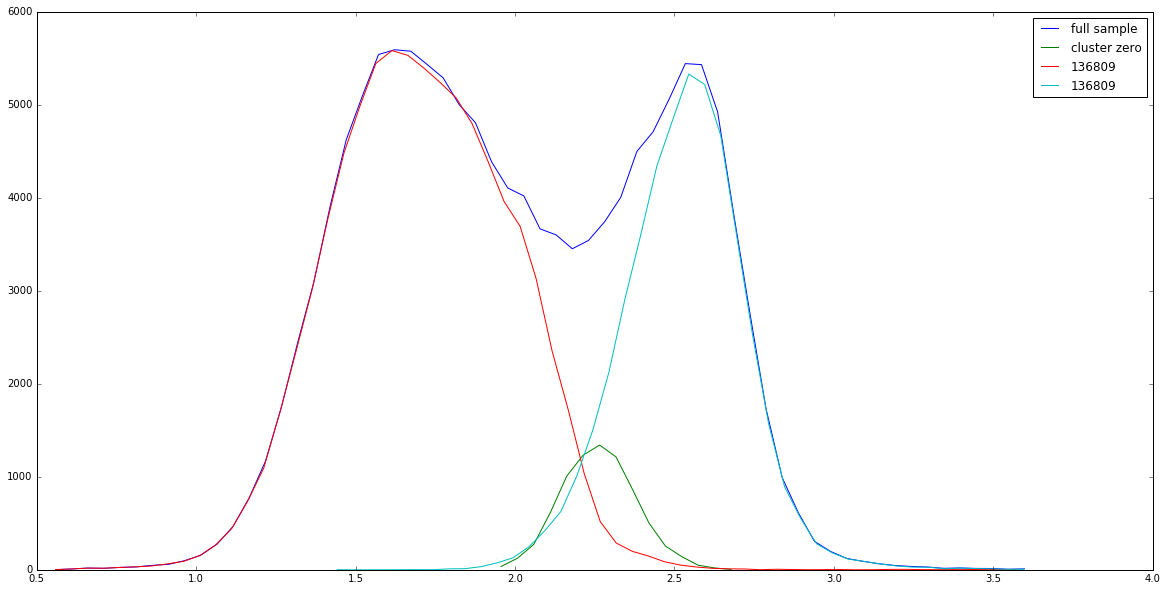

In [656]:
plt.figure(figsize=(20,10))
pt.plot_hist(y,200,'full sample',set_bin_size=True,bin_size=0.05,normed=False)
#pt.plot_hist(y[clusters_one == 1],200,'cluster one',set_bin_size=True,bin_size=0.05,normed=False)
pt.plot_hist(y[clusters_zero == 1],200,'cluster zero',set_bin_size=True,bin_size=0.05,normed=False)

#for i in range(2):
#    pt.plot_hist(y[cluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

pt.plot_hist(y1,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)
pt.plot_hist(y2,200,str(i),set_bin_size=True,bin_size=0.05,normed=False)

    
plt.legend()

(0.5, 3.5)

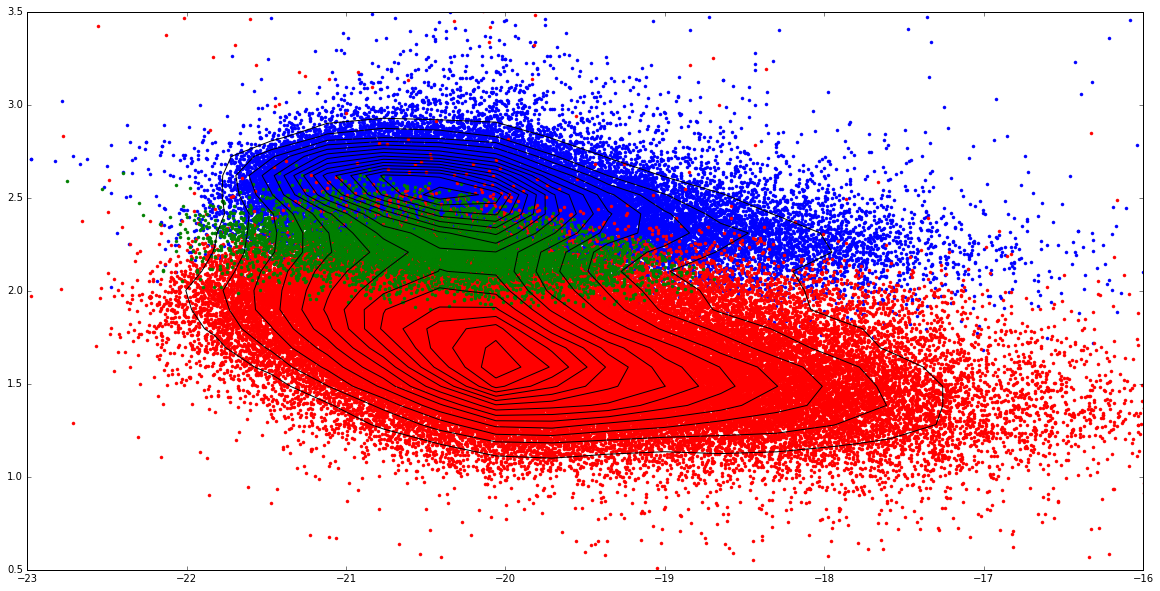

In [657]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,colours='k')
plt.plot(x2,y2,'b.')
plt.plot(x1,y1,'r.')
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'g.')

plt.xlim(-23,-16)
plt.ylim(0.5,3.5)

In [658]:
import scipy.stats as st

xmin, xmax = -23,-16
ymin, ymax = 0.5,3.5

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

KeyboardInterrupt: 

In [602]:
kernel.shape

AttributeError: 'gaussian_kde' object has no attribute 'shape'

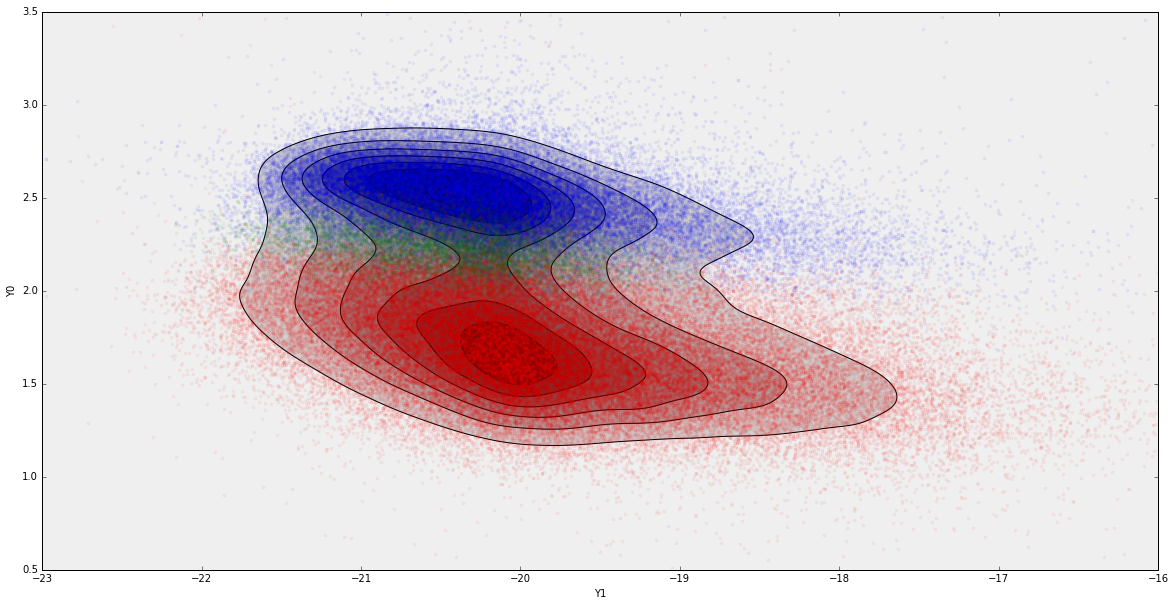

In [673]:
fig = pl.figure(figsize=(20,10))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='gray_r',l)
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

# Label plot
#ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

plt.plot(x2,y2,'b.',alpha=0.05)
plt.plot(x1,y1,'r.',alpha=0.05)
plt.plot(x[clusters_zero == 1],y[clusters_zero == 1],'g.',alpha=0.05)

# Contour plot
ax.contour(xx, yy, f, colors='k',alpha=1.)

pl.show()

(0.5, 3.5)

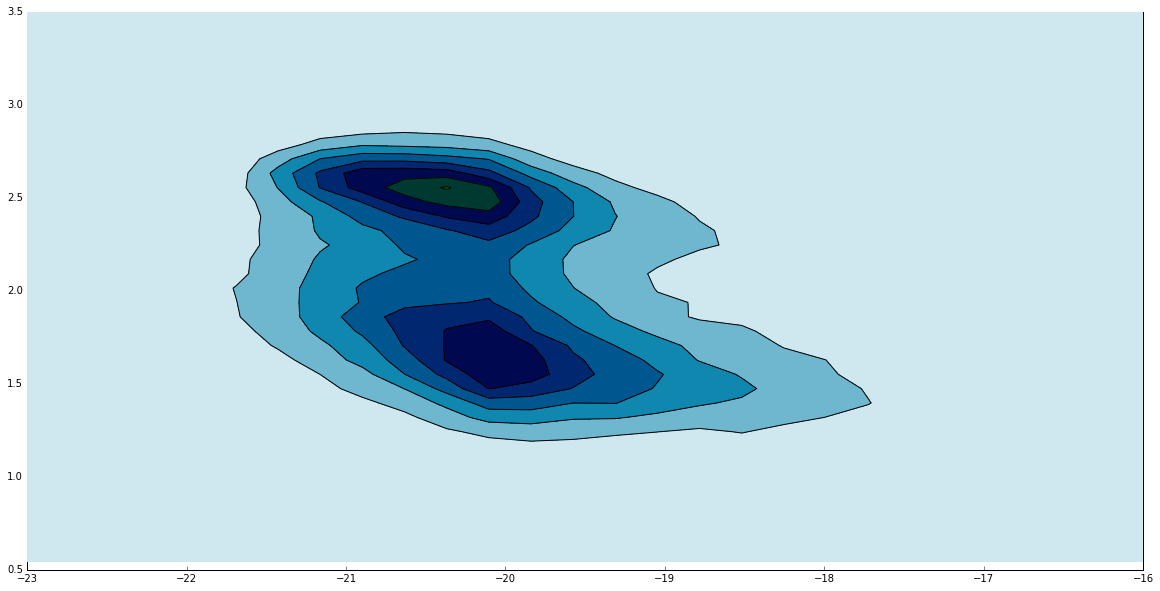

In [550]:
plt.figure(figsize=(20,10))

pt.plot_contour(x,y,fill=True,colours='ocean_r',lines=8,bins=40)
pt.plot_contour(x,y,colours='k',lines=8,bins=40)

plt.xlim(-23,-16)
plt.ylim(0.5,3.5)